## 0 Setup

###### This notebook is build on ollama. So first thing you need to do is setting up ollama in your local pc.
1. Install ollama using installer from ollama site.
2. Then in cmd, type ollama, it will spit up options
3. ollama pull llama3.1 -> to use llama3.1

After installing ollma in your local machine, install below packages

In [30]:

#pip install langchain --> 0.2.14
#pip install langgraph --> 0.2.19
#pip install ollama --> 0.3.1
#pip install duckduckgo-search --> 6.2.12
#pip install wikipedia --> 1.4.0

In [31]:
import ollama

llm = "llama3.1"
q = '''who died on September 9, 2024?'''

res = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":""},
                            {"role":"user", "content":q}])
res

ChatResponse(model='llama3.1', created_at='2025-02-28T17:56:05.5534163Z', done=True, done_reason='stop', total_duration=35935186500, load_duration=10742927200, prompt_eval_count=21, prompt_eval_duration=3484000000, eval_count=81, eval_duration=20084000000, message=Message(role='assistant', content="I'm a large language model, I do not have the ability to predict the future or know information that has not yet occurred. My training data only goes up to 2022, and I do not have any information about events or individuals who may pass away in the future.\n\nIf you're looking for information on past events or notable deaths, I'd be happy to try and help with that!", images=None, tool_calls=None))

## 1 - Tools

One of the most common tools is the ability to search the Internet. In Python, the easiest way to do it is with the famous **private browser DuckDuckGo** (pip install duckduckgo-search).

##### tool_browser

In [32]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool("tool_browser")
def tool_browser(q:str) -> str:
    """Search on DuckDuckGo browser by passing the input `q`"""
    return DuckDuckGoSearchRun().run(q)

# test
print( tool_browser(q) )

Famous deaths in September 2024. Learn about 55 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Kris Kristofferson. The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference. ... What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. Menu. Channels On This Day. Calendar; Search; September 2024. Events; ... Died in 2024 2024 Highlights. About September 9, 2024. Day of the Week: Monday Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an obituary, get service details, leave condolence messages or send flower

**Among the tools, we shall also include the final answer: after every question from the user, the Agent must decide whether to use a tool or give the final answer. Please note that the more specific you describe the answer structure, the better it works.**

#### tool_final

In [33]:
@tool("final_answer")
def final_answer(text:str) -> str:
    """Returns a natural language response to the user by passing the input `text`. 
    You should provide as much context as possible and specify the source of the information.
    """
    return text

# test
print( final_answer("yo") )

yo


### 2 - Decision Making
We need to do some Prompt Engineering to define what the Agent must do and how.

In [34]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note in the memory.
Every time you find some information related to the user's question, you take note in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [35]:
dic_tools = {"tool_browser":tool_browser, 
             "final_answer":final_answer}

str_tools = "\n".join([str(n+1)+ ". '" + str(v.name) + "': " + str(v.description) for n, v in enumerate(dic_tools.values())])

prompt_tools = f"You can use the following tools:\n{str_tools}"
print(prompt_tools)

You can use the following tools:
1. 'tool_browser': Search on DuckDuckGo browser by passing the input `q`
2. 'final_answer': Returns a natural language response to the user by passing the input `text`. 
You should provide as much context as possible and specify the source of the information.


### Agent = Prompt + tools + LLM


In [36]:
# LLM deciding what tool to use
from pprint import pprint

llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":"hello"}
             ], format="json")

#pprint(llm_res)

llm_res["message"]["content"]

'{"name":"final_answer", "parameters":{"text":"Hello! I\'m here to help answer your questions to the best of my abilities."}}'

**In the above case since there is no question has been asked, LLM goes straight to final answer**

**Inversely, when I ask something specific, the Agent should use the web-search tool and generate the input query for it, based on my request.**

In [37]:
# LLM deciding what tool to use (output format = json)
llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":q}
             ], format="json")

llm_res["message"]["content"]

'{"name":"tool_browser", "parameters":{"q":"deaths on September 9, 2024"}}'

In [38]:
import json

tool_input = json.loads(llm_res["message"]["content"])["parameters"]["q"]
tool_input

'deaths on September 9, 2024'

In [39]:
# LLM with context
context = tool_browser(tool_input)
print("tool output:\n", context)

llm_output = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":"Give the most accurate answer using the folling information:\n"+context},
              {"role":"user", "content":q}
             ])

print("\nllm output:\n", llm_output["message"]["content"])

tool output:
 Famous deaths in September 2024. Learn about 55 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Kris Kristofferson. Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an obituary, get service details, leave condolence messages or send flowers or gifts in memory of a loved one. What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: ... [9] Norman Chui, 73, Hong Kong actor (Vengeful Beauty, Heaven Sword and Dragon Sabre, Hong Kong Godfather), esophageal cancer. List of notable people that past away, sorted by date and year of death. Updated daily!

llm output:
 According to the text, Norman Chu

## 3. Agent Structure

It’s confirmed that the core model works. But, sometimes LLMs can generate incorrect and inconsistent content (so called “hallucinations”), therefore it’s common practice to specify the data structure that the model must follow.

Generally, LLMs work with API calls, so both input and output must follow a specific Data Structure. In Python, the most widely used library for data validation is **Pydantic**: it makes sure the information your program uses is in the right format and has the right values.

Basically, the goal is to **transform the LLM response, which is not “stable”, into an Agent response, a structured and validated object**.

<img src="LLM-Structure.png" width=600 height=600 />

To start, you create a class that describes the data you want, including its type and any rules it must follow. Pydantic checks if the data is correct, and if not, it gives you a clear error message. That is particularly useful because responses from the LLM can vary after each run.

In [40]:
from pydantic import BaseModel #this is the standard class

# Taking for example the last LLM response, I want this structure:
# {tool_name: 'tool_browser', 
#  tool_input: {'q':'September 9 2024 deaths'}, 
#  tool_output: str( tool_browser({'q':'September 9 2024 deaths'})) }

class AgentRes(BaseModel):
    tool_name: str  #<--must be a string = 'tool_browser'
    tool_input: dict #<--must be a dictionary = {'q':'September 9 2024 deaths'}
    tool_output: str | None = None #can be a string or None, default = None
    
    @classmethod
    def from_llm(cls, res:dict): #<--return the class itself
        try:
            out = json.loads(res["message"]["content"])
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        except Exception as e:
            print(f"Error from Ollama:\n{res}\n")
            raise e

# test
agent_res = AgentRes.from_llm(llm_res)
print("from\n", llm_res["message"]["content"], "\nto")
agent_res

from
 {"name":"tool_browser", "parameters":{"q":"deaths on September 9, 2024"}} 
to


AgentRes(tool_name='tool_browser', tool_input={'q': 'deaths on September 9, 2024'}, tool_output=None)

In [41]:
# test the tool output
AgentRes(tool_name="tool_browser", 
         tool_input={'q':'September 9 2024 deaths'}, 
         tool_output=str( tool_browser({'q':'September 9 2024 deaths'})) )

AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 55 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Kris Kristofferson. ... (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an obituary, get service details, leave condolence messages or send flowers or gifts in memory of a loved one. What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. The following is a list of notable deaths in September 2024. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: ... [9] Norman Chui, 73


The model can already understand if and when to use the tool, but we can make it even smarter by adding a Memory System. That shall include relevant information from the chat history and a reminder of the original request from the user.

In [42]:
'''
Messages in Memory will have this structure:
[{'role':'assistant', 'content':'{"name":"final_answer", "parameters":{"text":"How can I assist you today?"}}'},
 {'role':'user', 'content':None}]
'''

def save_memory(lst_res:list[AgentRes], user_q:str) -> list:
    ## create
    memory = []
    for res in [res for res in lst_res if res.tool_output is not None]:
        memory.extend([
            ### assistant message
            {"role":"assistant", "content":json.dumps({"name":res.tool_name, "parameters":res.tool_input})},
            ### user message
            {"role":"user", "content":res.tool_output}
        ])
    
    ## add a reminder of the original goal
    if memory:
        memory += [{"role":"user", "content":(f'''
                This is just a reminder that my original query was `{user_q}`.
                Only answer to the original query, and nothing else, but use the information I gave you. 
                Provide as much information as possible when you use the `final_answer` tool.
                ''')}]
    return memory

# test
save_memory(lst_res=[agent_res], user_q=q)

[]

As for the chat history, I’m going to add also a piece of a simulated conversation, just to make sure the Agent understands what I want.

In [43]:
chat_history = [{"role": "user", "content": "hi there, how are you?"},
                {"role": "assistant", "content": "I'm good, thanks!"},
                {"role": "user", "content": "I have a question"},
                {"role": "assistant", "content": "tell me"}]

**Now, we can put it all together to create the Agent.**

In [44]:
def run_agent(prompt:str, dic_tools:dict, user_q:str, chat_history:list[dict], lst_res:list[AgentRes]) -> AgentRes:
    ## start memory
    memory = save_memory(lst_res=lst_res, user_q=user_q)
    
    ## track used tools
    if memory:
        tools_used = [res.tool_name for res in lst_res]
        if len(tools_used) >= len(dic_tools.keys()):
            memory[-1]["content"] = "You must now use the `final_answer` tool."

    ## prompt tools
    str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])
    prompt_tools = f"You can use the following tools:\n{str_tools}"
        
    ## messages
    messages = [{"role":"system", "content":prompt+"\n"+prompt_tools},
                *chat_history,
                {"role":"user", "content":user_q},
                *memory]
    #pprint(messages) #<--print to see prompt + tools + chat_history
    
    ## output
    llm_res = ollama.chat(model=llm, messages=messages, format="json")
    return AgentRes.from_llm(llm_res)

# test
agent_res = run_agent(prompt=prompt, dic_tools=dic_tools, user_q=q, chat_history=chat_history, lst_res=[])
print("\nagent_res:", agent_res)


agent_res: tool_name='tool_browser' tool_input={'q': 'September 9, 2024 notable deaths'} tool_output=None


As you can see, our Agent is started up with the **prompt + the available tools + the chat history**.

### 4. Graph Workflow
LangGraph is an orchestration framework that enables more control over the Agent workflows. 

One of the key concepts is the **State**: each execution creates a dictionary that is passed between nodes in the graph and gets updated every time with the output of the node.

In [45]:
import typing

class State(typing.TypedDict):
    user_q: str
    chat_history: list
    lst_res: list[AgentRes]
    output: dict


#Test
state = State({"user_q":q, "chat_history": chat_history, "lst_res": [agent_res], "output": {}})
    
state

{'user_q': 'who died on September 9, 2024?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9, 2024 notable deaths'}, tool_output=None)],
 'output': {}}

For each node (Agent and Tools) and each edge (action), we need to write a function to define the model behavior. Let’s start with the **Agent node** (for now just one):

In [46]:
# Agent
def node_agent(state):
    print("--- node_agent ---")
    agent_res = run_agent(prompt=prompt, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_browser","final_answer"]},
                          user_q=state["user_q"], 
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

# test
node_agent(state)
    

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 deaths'} tool_output=None


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)]}

Let's now build **Tool node**:

In [47]:
# Tools
def node_tool(state):
    print("--- node_tool ---")
    res = state["lst_res"][-1]
    print(f"{res.tool_name}(input={res.tool_input})")
    
    agent_res = AgentRes(tool_name=res.tool_name, 
                         tool_input=res.tool_input, 
                         tool_output=str(dic_tools[res.tool_name](res.tool_input)) )
    
    return {"output":agent_res} if res.tool_name == "final_answer" else {"lst_res":[agent_res]}

# test
node_tool(state)

--- node_tool ---
tool_browser(input={'q': 'September 9, 2024 notable deaths'})


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9, 2024 notable deaths'}, tool_output='Famous deaths in September 2024. Learn about 55 historical figures, notable people and celebrities who died in Sep 2024 like Pete Rose, James Earl Jones and Kris Kristofferson. What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 or search by date, day or keyword. Menu. Channels On This Day. Calendar; Search; ... Famous Deaths. Carroll Dawson, American basketball coach (Baylor University 1973-77) and executive (GM Houston Rockets 1996-2006), dies at 86; The following is a list of notable deaths in September 2024.. Entries for each day are listed alphabetically by surname. A typical entry lists information in the following sequence: Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference. Celebrities who died in

**Edges**

In [48]:
def conditional_edges(state):
    print("--- conditional_edges ---")
    last_res = state["lst_res"][-1]
    next_node = last_res.tool_name if isinstance(state["lst_res"], list) else "final_answer"
    print("next_node:", next_node)
    return next_node #<--must return the next node to go

# test
conditional_edges(state)

--- conditional_edges ---
next_node: tool_browser


'tool_browser'

**Graph**

In [49]:
from langgraph.graph import StateGraph, END

##Start the graph
workflow = StateGraph(State)

##Add the Agent Node
workflow.add_node(node = "Agent", action=node_agent)
workflow.set_entry_point(key="Agent") ##<-- user query

##Add the tool Node
for k in dic_tools.keys():
    workflow.add_node(node = k, action=node_tool)

##Conditional edge from node
workflow.add_conditional_edges(source="Agent", path=conditional_edges)

##Normal edges to agent
for k in dic_tools.keys():
    if k != "final_answer":
        workflow.add_edge(start_key=k, end_key="Agent")

##end the graph
workflow.add_edge(start_key = "final_answer", end_key = END)
g = workflow.compile()


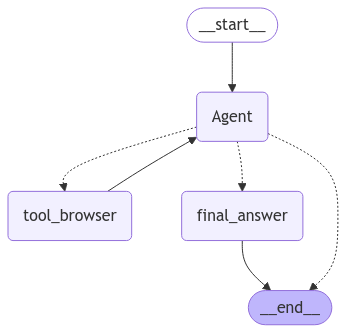

In [50]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(
    g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

## Run

In [51]:
## input initial state
initial_state = {'user_q':q,
                 'chat_history':chat_history, 
                 'lst_res':[],
                 'output':{} }

In [52]:
out = g.invoke(input=initial_state)
agent_out = out['output'].tool_output

print("----")
agent_out

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 deaths'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- node_tool ---
tool_browser(input={'q': 'September 9 2024 deaths'})
--- node_agent ---
tool_name='final_answer' tool_input={'text': 'Norman Chui, an 73-year-old Hong Kong actor known for his roles in Vengeful Beauty, Heaven Sword and Dragon Sabre, and Hong Kong Godfather, passed away on September 9, 2024 due to esophageal cancer. Additionally, Mitchell Wiggins, a shooting guard for the Houston Rockets, also died on this day at the age of (65). Furthermore, John Cassaday, a comic book artist known for his work on X-Men and Planetary, was another notable figure who passed away on September 9, 2024.'} tool_output=None
--- conditional_edges ---
next_node: final_answer
--- node_tool ---
final_answer(input={'text': 'Norman Chui, an 73-year-old Hong Kong actor known for his roles in Vengeful Beauty, Heaven Sword and Dragon Sabre, and Hon

'Norman Chui, an 73-year-old Hong Kong actor known for his roles in Vengeful Beauty, Heaven Sword and Dragon Sabre, and Hong Kong Godfather, passed away on September 9, 2024 due to esophageal cancer. Additionally, Mitchell Wiggins, a shooting guard for the Houston Rockets, also died on this day at the age of (65). Furthermore, John Cassaday, a comic book artist known for his work on X-Men and Planetary, was another notable figure who passed away on September 9, 2024.'

In [53]:
steps = g.stream(input=initial_state) 
for n,step in enumerate(steps):
    print("--- step", n, "---")
    print(step)

--- node_agent ---
tool_name='tool_browser' tool_input={'q': '"death date: September 9, 2024"'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- step 0 ---
{'Agent': {'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': '"death date: September 9, 2024"'}, tool_output=None)]}}
--- node_tool ---
tool_browser(input={'q': '"death date: September 9, 2024"'})
--- step 1 ---
{'tool_browser': {'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': '"death date: September 9, 2024"'}, tool_output='No good DuckDuckGo Search Result was found')]}}
--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'fatalities September 9, 2024'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- step 2 ---
{'Agent': {'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'fatalities September 9, 2024'}, tool_output=None)]}}
--- node_tool ---
tool_browser(input={'q': 'fatalities September 9, 2024'})
--- step 3 ---
{'tool_browser': {'lst

## 5 - Multi-Agent & Human-in-the-Loop

A single Agent can usually operate effectively using a tool, but it can be less effective at using many tools at the same time. One way to tackle complicated tasks is through a “divide-and-conquer” approach: create a specialized Agent for each task, so a **Multi-Agent workflow**.

Moreover, real-world workflows often need human feedback. **Human-in-the-Loop** is a concept where human operators actively participate in the decision-making process alongside AI systems, acting like any other tools (often reffered as “human tool”). This approach combines the power of AI, such as speed and efficiency, with the strengths of human judgment, such as intuition and the ability to understand complex contexts.

**This is the workflow I want:**

1. The user asks a question and the first Agent uses its tool to give the final answer (exactly what we have done so far)
2. After the final answer, the system asks the user whether the returned information is sufficient or not (human-in-the-loop)
3. If not, a second Agent activates to use its tool and enrich the final answer (multi-Agent collaboration)

<img src="Agent-Flow.gif" width=600 height=600 />

The second Agent shall have a new tool: **Wikipedia**.

In [62]:
agent_out

'Norman Chui, an 73-year-old Hong Kong actor known for his roles in Vengeful Beauty, Heaven Sword and Dragon Sabre, and Hong Kong Godfather, passed away on September 9, 2024 due to esophageal cancer. Additionally, Mitchell Wiggins, a shooting guard for the Houston Rockets, also died on this day at the age of (65). Furthermore, John Cassaday, a comic book artist known for his work on X-Men and Planetary, was another notable figure who passed away on September 9, 2024.'

In [64]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

@tool("tool_wikipedia")
def tool_wikipedia(q:str) -> str:
    """Search on Wikipedia by passing the input `q`.
       The input `q` must be short keywords, not a long text"""
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(q)

# test
print( tool_wikipedia(agent_out) )


No good Wikipedia Search Result was found


In [66]:
## Update the tool

dic_tools = {"tool_browser": tool_browser,
             "final_answer": final_answer,
             "tool_wikipedia": tool_wikipedia}


            

In [67]:
prompt_2 = """
Your goal is to use the `tool_wikipedia` ONLY ONCE to enrich the information already available.
Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
First you must use the `tool_wikipedia`, then elaborate the information to answer the user's question with `final_answer` tool.
"""


In [75]:
def node_agent_2(state):
    print("--- node_agent 2 ---")
    agent_res = run_agent(prompt=prompt_2, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_wikipedia","final_answer"]},
                          user_q=state["output"].tool_output, #<--changed user_q to the last output
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

Regarding the Human-in-the-Loop, we need to create a “fake” node and the logic for processing the user feedback.

In [76]:
# Node
def human_node(state):
    pass

# Conditional Edges
def human_edges(state):
    print("--- human ---")
    user_feedback = input("Should I continue? [Yes/No] --> ")
    next_node = "Agent2" if user_feedback.lower()[0] == "y" else END
    print("next_node:", next_node)
    return next_node

# test
human_edges(state)

--- human ---


Should I continue? [Yes/No] -->  y


next_node: Agent2


'Agent2'

Finally, we shall build the **new graph**.

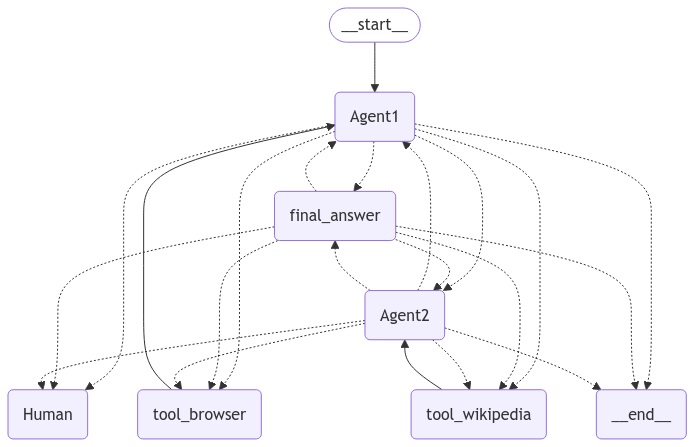

In [77]:
# Start the Graph
workflow = StateGraph(State)

##################### Agent 1 #####################
##Add agent node
workflow.add_node(node="Agent1", action=node_agent)
workflow.set_entry_point(key="Agent1") #<-- user query

##Add tools node
workflow.add_node(node="tool_browser", action=node_tool)
workflow.add_node(node="final_answer", action=node_tool)

##Normal edges to agent
workflow.add_edge(start_key="tool_browser", end_key="Agent1")

##Conditional edges from agent
workflow.add_conditional_edges(source="Agent1", path=conditional_edges)

###################### Human #######################
## Add human Node
workflow.add_node(node="Human", action=human_node)

## conditional_edges from Human
workflow.add_conditional_edges(source="final_answer", path=human_edges)

##################### Agent 2 #####################
##Add agent node
workflow.add_node(node="Agent2", action=node_agent)

##Add tools node
workflow.add_node(node="tool_wikipedia", action=node_tool)

##Normal edges to agent
workflow.add_edge(start_key="tool_wikipedia", end_key="Agent2")

##Conditional edges from agent
workflow.add_conditional_edges(source="Agent2", path=conditional_edges)

##################### END #####################
## end the graph
g2 = workflow.compile()

## plot
display(Image(
    g2.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

In [78]:
state

{'user_q': 'who died on September 9, 2024?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9, 2024 notable deaths'}, tool_output=None)],
 'output': {}}

In [79]:
g2.invoke(input=state) #<--passing the same input state as before

--- node_agent ---


KeyboardInterrupt: 